## Adobe GenSolve 2024 Round 2

**Team:**
- **Sakshi Kumari**
- **Aditya Raj**  (Team Lead)

Email (Team Lead):
adityar.ug22.ec@nitp.ac.in


In [1]:
import sys
import cv2
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np

from scipy.spatial import KDTree

from PIL import Image
import seaborn as sns
import glob

In [2]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt

### Dataset

#### Adobe Test Dataset

In [3]:
import gdown
!gdown 1VBNAma4SSMDZ8WAvDVQBj7vTQoR38MqO

zip_file_path = 'problems.zip'
extract_dir = '/content/problems'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Downloading...
From: https://drive.google.com/uc?id=1VBNAma4SSMDZ8WAvDVQBj7vTQoR38MqO
To: /content/problems.zip
100% 348k/348k [00:00<00:00, 74.5MB/s]


#### Synthetic Dataset

In [4]:
import gdown
!gdown 1Xc4CHr5fszMNypeDHaQiBrMzeO57nWKi

zip_file_path = 'dataset.zip'
extract_dir = '/content/dataset'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1Xc4CHr5fszMNypeDHaQiBrMzeO57nWKi
From (redirected): https://drive.google.com/uc?id=1Xc4CHr5fszMNypeDHaQiBrMzeO57nWKi&confirm=t&uuid=cd0afe35-e431-42e7-aff5-6fb651036e79
To: /content/dataset.zip
100% 49.5M/49.5M [00:01<00:00, 38.0MB/s]


In [ ]:
!pip install opencv-contrib-python

### Symmetry

In [ ]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

class Mirror_Symmetry_detection:
    def __init__(self, image_path: str):
        self.image = self._read_color_image(image_path)
        self.reflected_image = np.fliplr(self.image)
        self.kp1, self.des1 = sift.detectAndCompute(self.image, None)
        self.kp2, self.des2 = sift.detectAndCompute(self.reflected_image, None)

    def _read_color_image(self, image_path):
        image = cv2.imread(image_path)
        b, g, r = cv2.split(image)
        image = cv2.merge([r, g, b])
        return image

    def find_matchpoints(self):
        matches = bf.knnMatch(self.des1, self.des2, k=2)
        matchpoints = [item[0] for item in matches]
        matchpoints = sorted(matchpoints, key=lambda x: x.distance)
        return matchpoints

    def find_points_r_theta(self, matchpoints):
        points_r = []
        points_theta = []
        for match in matchpoints:
            point = self.kp1[match.queryIdx]
            mirpoint = self.kp2[match.trainIdx]
            mirpoint.angle = np.deg2rad(mirpoint.angle)
            mirpoint.angle = np.pi - mirpoint.angle
            if mirpoint.angle < 0.0:
                mirpoint.angle += 2 * np.pi
            mirpoint.pt = (self.reflected_image.shape[1] - mirpoint.pt[0], mirpoint.pt[1])
            theta = angle_with_x_axis(point.pt, mirpoint.pt)
            xc, yc = midpoint(point.pt, mirpoint.pt)
            r = xc * np.cos(theta) + yc * np.sin(theta)
            points_r.append(r)
            points_theta.append(theta)
        return points_r, points_theta

    def draw_mirrorLine(self, r, theta, title):
        for y in range(len(self.image)):
            try:
                x = int((r - y * np.sin(theta)) / np.cos(theta))
                self.image[y][x] = 255
                self.image[y][x + 1] = 255
            except IndexError:
                continue
        plt.imshow(self.image)
        plt.axis('off')
        plt.title(title)
        plt.show()

    def sort_hexbin_by_votes(self, image_hexbin):
        counts = image_hexbin.get_array()
        verts = image_hexbin.get_offsets()
        output = {}
        for offc in range(verts.shape[0]):
            binx, biny = verts[offc][0], verts[offc][1]
            if counts[offc]:
                output[(binx, biny)] = counts[offc]
        return {k: v for k, v in sorted(output.items(), key=lambda item: item[1], reverse=True)}

    def find_coordinate_maxhexbin(self, image_hexbin, sorted_vote, vertical):
        for k, v in sorted_vote.items():
            if vertical:
                return k[0], k[1]
            else:
                if k[1] == 0 or k[1] == np.pi:
                    continue
                else:
                    return k[0], k[1]

def angle_with_x_axis(pi, pj):
    x, y = pi[0] - pj[0], pi[1] - pj[1]
    if x == 0:
        return np.pi / 2
    angle = np.arctan(y / x)
    if angle < 0:
        angle += np.pi
    return angle

def midpoint(pi, pj):
    return (pi[0] + pj[0]) / 2, (pi[1] + pj[1]) / 2

def symmetry_detect(image_path: str):
    mirror = Mirror_Symmetry_detection(image_path)
    matchpoints = mirror.find_matchpoints()
    points_r, points_theta = mirror.find_points_r_theta(matchpoints)
    image_hexbin = plt.hexbin(points_r, points_theta, bins=200, cmap=plt.cm.Spectral_r)
    sorted_vote = mirror.sort_hexbin_by_votes(image_hexbin)
    r, theta = mirror.find_coordinate_maxhexbin(image_hexbin, sorted_vote, vertical=False)
    mirror.draw_mirrorLine(r, theta, "Image with Symmetry Line")

    symmetry_type = ""
    if np.isclose(theta, 0, atol=np.pi/12) or np.isclose(theta, np.pi, atol=np.pi/12):
        symmetry_type = "Vertical Symmetry"
    elif np.isclose(theta, np.pi/2, atol=np.pi/12):
        symmetry_type = "Horizontal Symmetry"
    else:
        symmetry_type = "Diagonal Symmetry"

    print(f"Detected Symmetry Type: {symmetry_type}")
    return mirror.image


### Load Data

In [ ]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs



In [ ]:
def plot(path_XYs, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()

# csv_path = '/content/problems/problems/frag1.csv'
# plot(read_csv(csv_path), 'r')

In [ ]:
def plot_png(path_XYs, colours, save_path='plot.png'):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

# csv_path = '/content/problems/problems/frag1.csv'
# plot_png(read_csv(csv_path), 'r', save_path='output_plot.png')

### Regularisation

In [ ]:
!pip install bezier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.
accelerate 0.32.1 requires numpy<2.0.0,>=1.17, but you have numpy 2.0.1 which is incompatible.
albucore 0.0.13 requires numpy<2,>=1.24.4, but you have numpy 2.0.1 which is incompatible.
arviz 0.18.0 requires numpy<2.0,>=1.23.0, but you have numpy 2.0.1 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a

In [ ]:
from shapely.geometry import Polygon, Point, LineString
import matplotlib.patches as patches
from shapely.affinity import scale
from shapely.geometry.polygon import orient
from shapely.geometry import Polygon

import bezier
from bezier import Curve

In [ ]:
class ShapeRegularizer:
    def __init__(self, num_points=100, alpha=0.1):
        self.num_points = num_points
        self.alpha = alpha

    def regularize_polygon(self, polygon):
        coords = np.array(polygon.exterior.coords)
        if len(coords) < 4:
            return polygon

        new_coords = []
        for i in range(len(coords)):
            prev_idx = (i - 1) % len(coords)
            next_idx = (i + 1) % len(coords)
            new_x = (1 - self.alpha) * coords[i][0] + self.alpha * (coords[prev_idx][0] + coords[next_idx][0]) / 2
            new_y = (1 - self.alpha) * coords[i][1] + self.alpha * (coords[prev_idx][1] + coords[next_idx][1]) / 2
            new_coords.append((new_x, new_y))
        return Polygon(new_coords)

    def regularize_rectangle(self, rectangle):
        coords = np.array(rectangle.exterior.coords)
        min_x, min_y = coords.min(axis=0)
        max_x, max_y = coords.max(axis=0)
        rect_coords = [(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y), (min_x, min_y)]
        return Polygon(rect_coords)

    def regularize_square(self, square):
        coords = np.array(square.exterior.coords)
        min_x, min_y = coords.min(axis=0)
        max_x, max_y = coords.max(axis=0)
        side_length = min(max_x - min_x, max_y - min_y)
        new_coords = [(min_x, min_y), (min_x + side_length, min_y),
                      (min_x + side_length, min_y + side_length), (min_x, min_y + side_length), (min_x, min_y)]
        return Polygon(new_coords)

    def regularize_circle(self, circle):
        center = circle.centroid
        coords = np.array(circle.exterior.coords)
        distances = np.linalg.norm(coords - np.array([center.x, center.y]), axis=1)
        radius = np.mean(distances)
        angles = np.linspace(0, 2 * np.pi, self.num_points, endpoint=False)
        circle_coords = [(center.x + radius * np.cos(angle), center.y + radius * np.sin(angle)) for angle in angles]
        circle_coords.append(circle_coords[0])
        return Polygon(circle_coords)

    def regularize_ellipse(self, ellipse):
        try:
            (x, y), (MA, ma), angle = cv2.fitEllipse(np.array(ellipse.exterior.coords))
            major_axis = MA / 2
            minor_axis = ma / 2
            center = Point(x, y)
            angles = np.linspace(0, 2 * np.pi, self.num_points, endpoint=False)
            ellipse_coords = [(center.x + major_axis * np.cos(angle), center.y + minor_axis * np.sin(angle)) for angle in angles]
            return Polygon(ellipse_coords)
        except cv2.error:
            return ellipse

    def regularize_triangle(self, triangle):
        coords = np.array(triangle.exterior.coords)
        if len(coords) != 4:
            return triangle

        centroid = np.mean(coords[:-1], axis=0)

        side_lengths = [np.linalg.norm(coords[i] - coords[(i+1) % 3]) for i in range(3)]
        max_side = max(side_lengths)
        new_coords = []
        for i in range(3):
            x = centroid[0] + (coords[i][0] - centroid[0]) * max_side / side_lengths[i]
            y = centroid[1] + (coords[i][1] - centroid[1]) * max_side / side_lengths[i]
            new_coords.append((x, y))
        new_coords.append(new_coords[0])
        return Polygon(new_coords)

    def is_star_shape(contour):
        contour = np.squeeze(contour)
        if contour.ndim == 1:
            contour = contour.reshape(-1, 2)

        if len(contour) != 10 and len(contour) != 11:
            return False

        polygon = Polygon(contour)
        angles = []
        for i in range(len(contour)):
            pt1, pt2, pt3 = contour[i], contour[(i + 1) % len(contour)], contour[(i + 2) % len(contour)]
            vec1 = pt2 - pt1
            vec2 = pt3 - pt2
            angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
            angles.append(np.degrees(angle))

        star_criteria = all(25 <= angle <= 45 or 135 <= angle <= 155 for angle in angles)

        hull = cv2.convexHull(contour)
        hull_polygon = Polygon(hull.squeeze())
        convex_ratio = hull_polygon.area / polygon.area

        return star_criteria and convex_ratio > 1.3

    def classify_shape(self, contour):
        contour = np.squeeze(contour)
        if contour.ndim == 1:
            contour = contour.reshape(-1, 2)

        if contour.shape[0] < 3:
            return 'unknown'

        poly = Polygon(contour)

        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(np.array(contour), epsilon, True)
        num_vertices = len(approx)

        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        if perimeter == 0:
            return 'unknown'

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > 0.8 and self.is_nearly_circular(contour):
            return 'circle'

        try:
            (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
            if MA / ma > 1.5:
                return 'ellipse'
        except cv2.error:
            pass

        if num_vertices == 4:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h
            if 0.95 < aspect_ratio < 1.05:
                return 'square'
            else:
                return 'rectangle'

        if num_vertices == 3:
            if self.is_triangle_by_angle(contour):
                return 'triangle'

        if num_vertices == 10 or num_vertices == 11:
            if self.is_star_shape(contour):
                return 'star'

        if num_vertices > 5:
            return 'polygon'

        return 'unknown'

    def is_nearly_circular(self, contour):
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(np.array(contour), epsilon, True)
        num_vertices = len(approx)

        if num_vertices > 4:
            return True

        return False

    def is_triangle_by_angle(self, contour):
        contour = np.array(contour)
        angles = []
        for i in range(3):
            pt1, pt2, pt3 = contour[i % 3], contour[(i + 1) % 3], contour[(i + 2) % 3]
            vec1 = pt2 - pt1
            vec2 = pt3 - pt2
            angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
            angles.append(np.degrees(angle))

        if np.isclose(sum(angles), 180, atol=5) and all(50 <= angle <= 80 for angle in angles):
            return True
        return False

    def is_star_shape(self, contour):
        contour = np.squeeze(contour)
        if contour.ndim == 1:
            contour = contour.reshape(-1, 2)

        if len(contour) != 10 and len(contour) != 11:
            return False

        angles = []
        for i in range(len(contour) - 1):
            pt1, pt2, pt3 = contour[i], contour[(i + 1) % len(contour)], contour[(i + 2) % len(contour)]
            vec1 = pt2 - pt1
            vec2 = pt3 - pt2
            angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
            angles.append(np.degrees(angle))

        star_criteria = all(25 <= angle <= 45 or 135 <= angle <= 155 for angle in angles)
        return star_criteria

    def regularize_shape(self, contour):
        contour = np.squeeze(contour)
        if contour.ndim == 1:
            contour = contour.reshape(-1, 2)
        if contour.shape[0] < 3:
            return Polygon(contour)
        poly = Polygon(contour)
        shape_type = self.classify_shape(contour)
        if shape_type == 'rectangle':
            return self.regularize_rectangle(poly)
        elif shape_type == 'square':
            return self.regularize_square(poly)
        elif shape_type == 'circle':
            return self.regularize_circle(poly)
        elif shape_type == 'ellipse':
            return self.regularize_ellipse(poly)
        elif shape_type == 'triangle':
            return self.regularize_triangle(poly)
        elif shape_type == 'star':
            return self.regularize_star(poly)
        elif shape_type == 'polygon':
            return self.regularize_polygon(poly)
        else:
            return poly

    def draw_regularized_shapes(self, image, contours):
        output_image = np.zeros_like(image)
        for contour in contours:
            regularized_shape = self.regularize_shape(contour)
            if len(regularized_shape.exterior.coords) < 4:
                continue
            regularized_coords = np.array(regularized_shape.exterior.coords, dtype=np.int32)
            cv2.polylines(output_image, [regularized_coords], isClosed=True, color=(255, 255, 255), thickness=2)
        return output_image.astype(np.uint8)

class ImageProcessor:
    @staticmethod
    def preprocess_image(image_path, invert=True):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError(f"Image not found at {image_path}")
        _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY)
        if binary is None:
            raise ValueError("Thresholding failed.")
        return binary.astype(np.uint8)

    @staticmethod
    def extract_contours(binary_image):
        contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        return contours

class ShapeRegularizationPipeline:
    def __init__(self, num_points=100, alpha=0.1):
        self.regularizer = ShapeRegularizer(num_points=num_points, alpha=alpha)

    def regularize(self, input_path, output_path):
        binary_image = ImageProcessor.preprocess_image(input_path, invert=True)
        contours = ImageProcessor.extract_contours(binary_image)
        output_image = self.regularizer.draw_regularized_shapes(binary_image, contours)
        cv2.imwrite(output_path, output_image)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(binary_image, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title("Regularized Shapes")
        plt.imshow(output_image, cmap='gray')
        plt.show()

In [ ]:
from google.colab.patches import cv2_imshow

Original Image
--------------


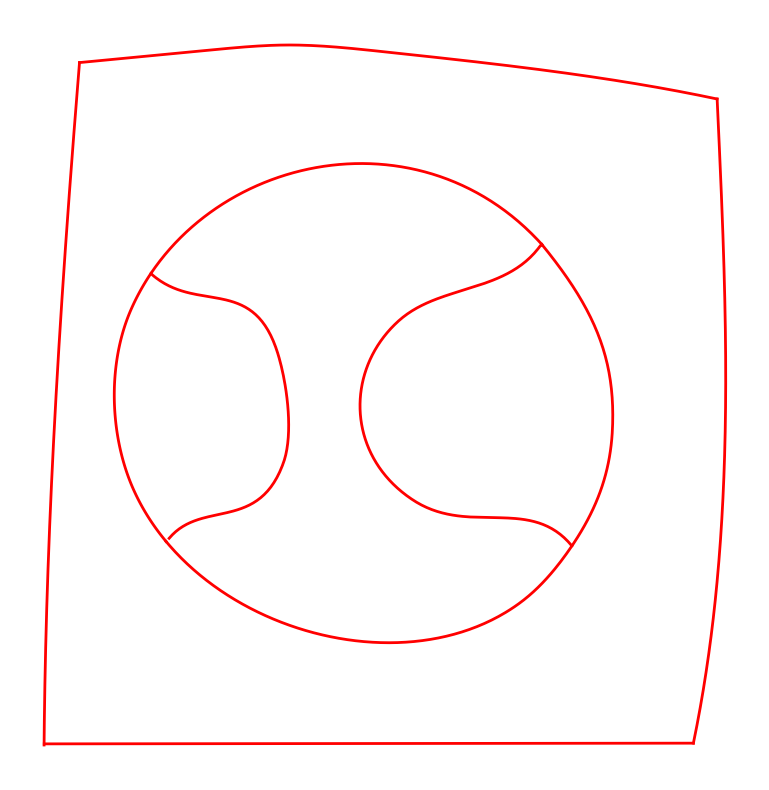

Regualrised Image
--------------


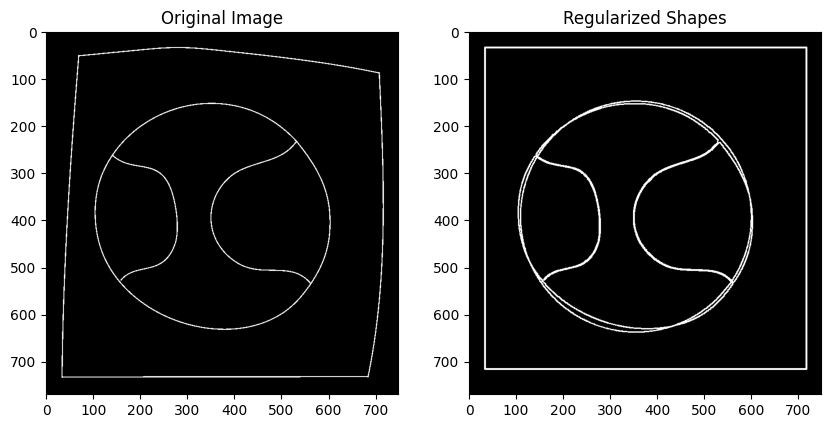

Symmetry Image
--------------


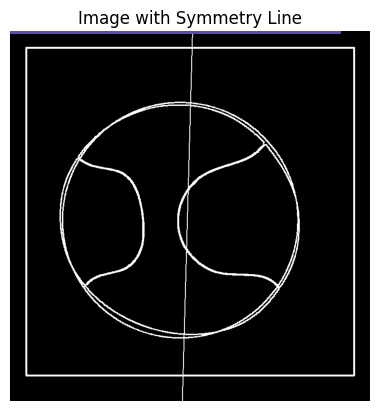

Detected Symmetry Type: Vertical Symmetry


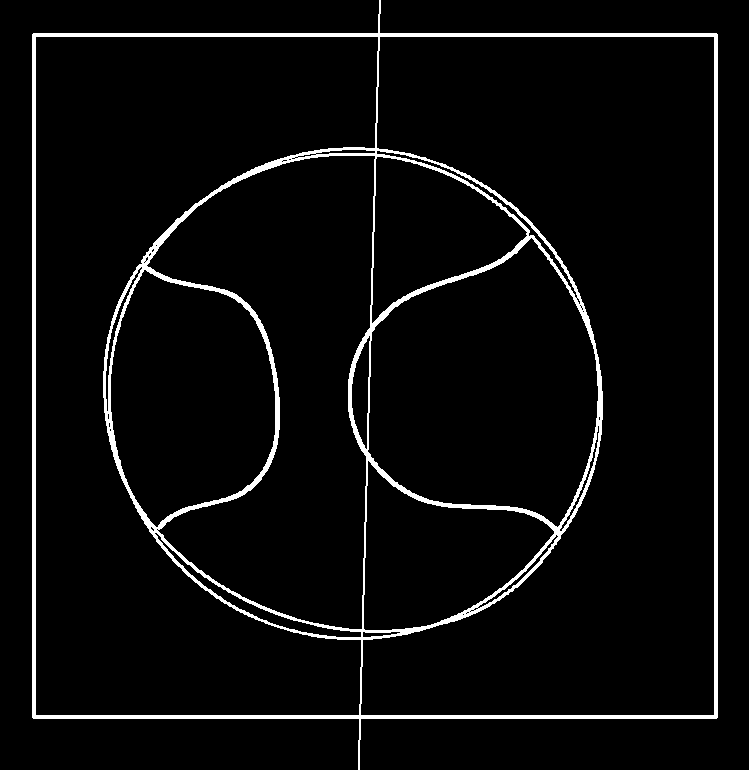

In [ ]:
csv_path = '/content/problems/problems/frag1.csv'
print("Original Image")
print("--------------")
plot_png(read_csv(csv_path), 'r', save_path='output_plot1.png')


pipeline = ShapeRegularizationPipeline(num_points=1000, alpha=0.9)
print("Regualrised Image")
print("--------------")
pipeline.regularize(f'/content/output_plot1.png', '/content/output_regularised1.png')


print("Symmetry Image")
print("--------------")
result_image = symmetry_detect('output_regularised1.png')
cv2_imshow(result_image)

Original Image
--------------


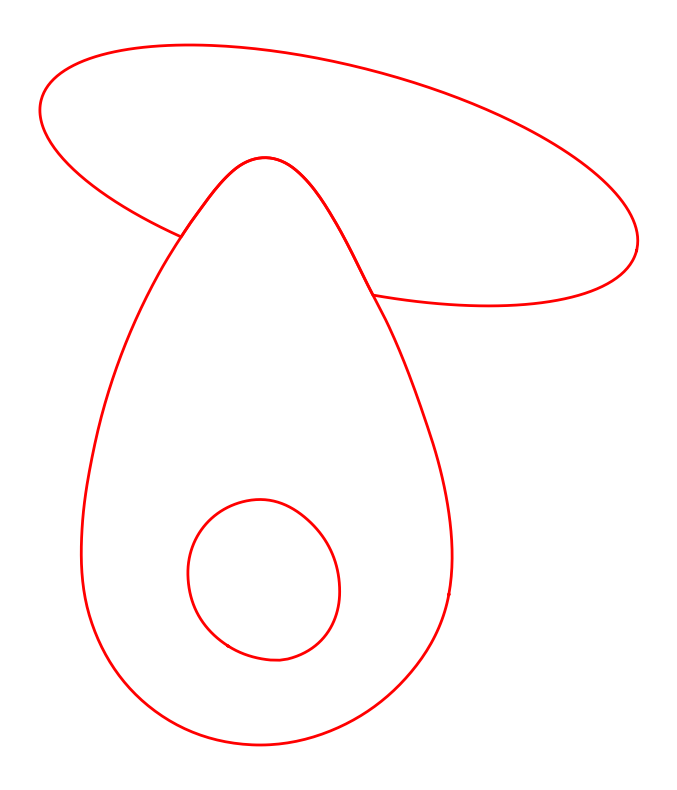

Regualrised Image
--------------


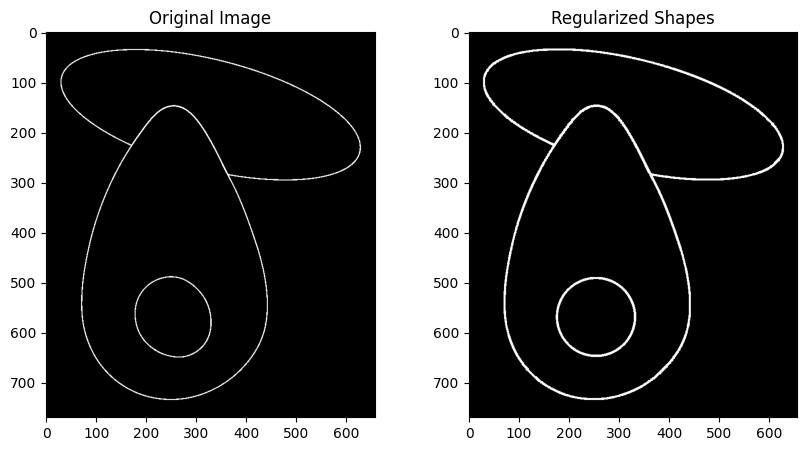

Symmetry Image
--------------


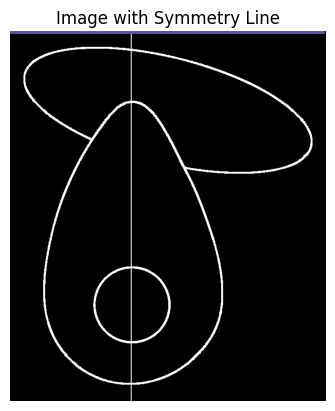

Detected Symmetry Type: Vertical Symmetry


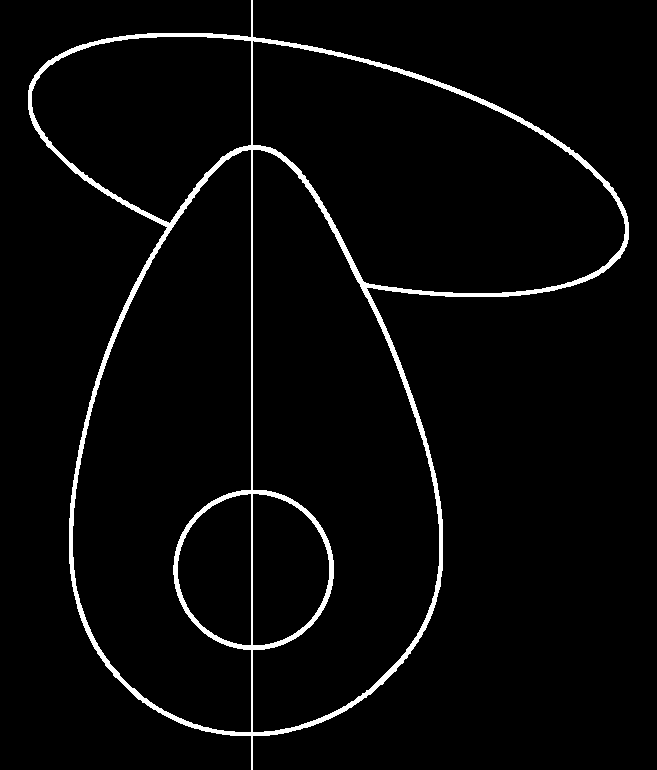

In [ ]:
print("Original Image")
print("--------------")
csv_path = '/content/problems/problems/occlusion1.csv'
plot_png(read_csv(csv_path), 'r', save_path='output_plot2.png')


print("Regualrised Image")
print("--------------")
pipeline = ShapeRegularizationPipeline(num_points=1000, alpha=0.9)
pipeline.regularize(f'/content/output_plot2.png', '/content/output_regularised2.png')


print("Symmetry Image")
print("--------------")
result_image = symmetry_detect('output_regularised2.png')
cv2_imshow(result_image)

Original Image
--------------


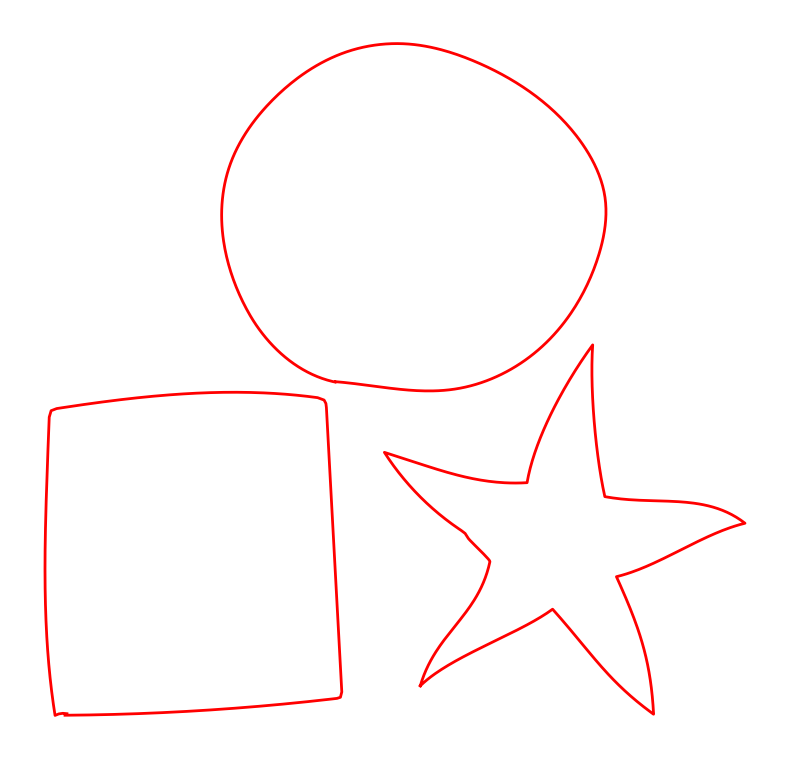

Regualrised Image
--------------


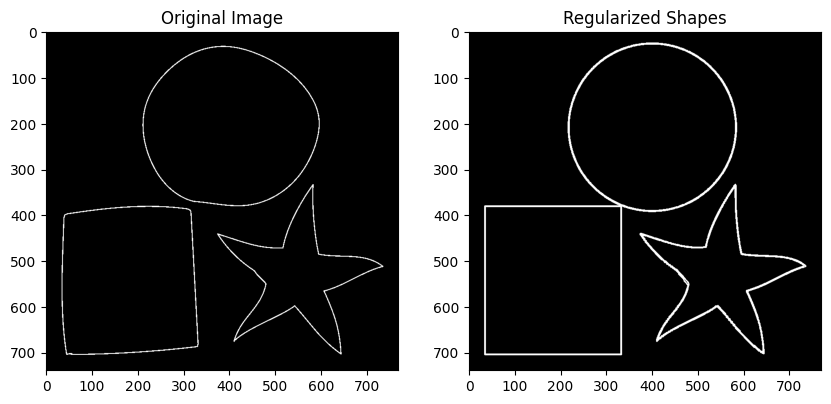

In [ ]:
print("Original Image")
print("--------------")
csv_path = '/content/problems/problems/isolated.csv'
plot_png(read_csv(csv_path), 'r', save_path='output_plot3.png')


pipeline = ShapeRegularizationPipeline(num_points=1000, alpha=0.9)
print("Regualrised Image")
print("--------------")
pipeline.regularize(f'/content/output_plot3.png', '/content/output_regularised3.png')

Regualrised Image
--------------


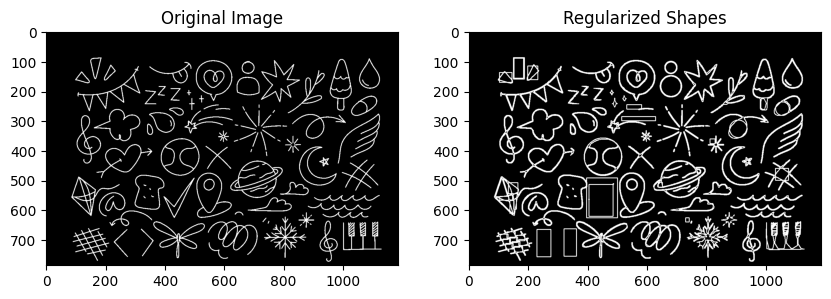

In [ ]:
# Here, doodle is the image on the second page of the problem statement pdf

pipeline = ShapeRegularizationPipeline(num_points=1000, alpha=0.9)
print("Regualrised Image")
print("--------------")
pipeline.regularize(f'/content/doodle.png', '/content/output_regularised4.png')

Original Image
--------------


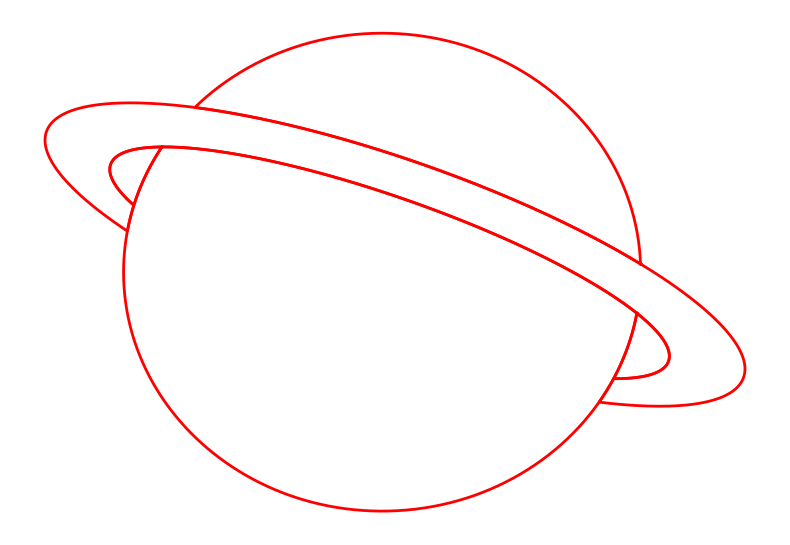

Regualrised Image
--------------


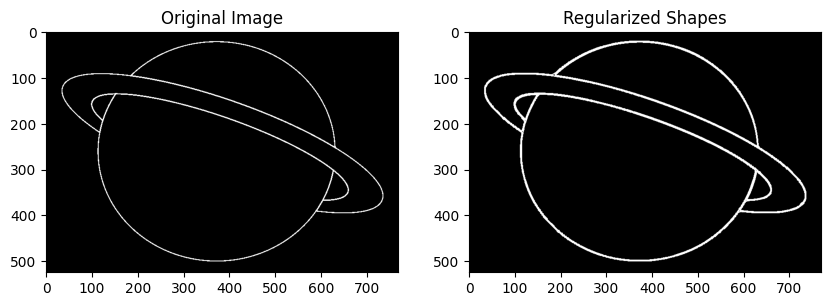

Symmetry Image
--------------


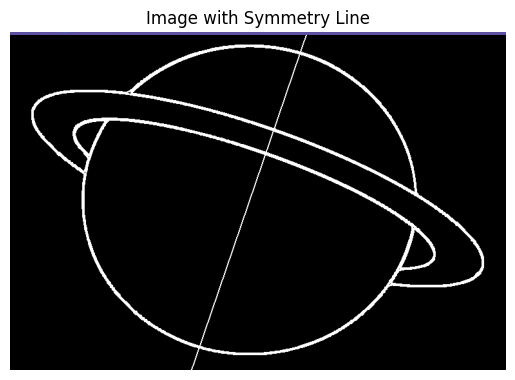

Detected Symmetry Type: Diagonal Symmetry


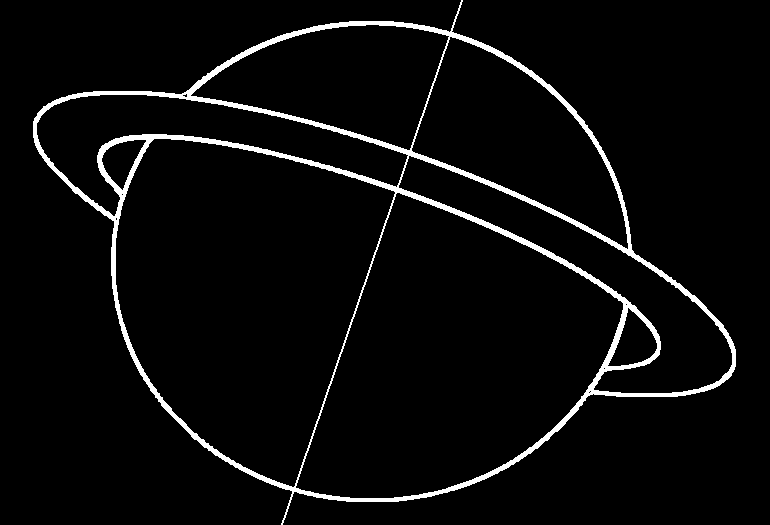

In [ ]:
print("Original Image")
print("--------------")
csv_path = '/content/problems/problems/occlusion2.csv'
plot_png(read_csv(csv_path), 'r', save_path='output_plot5.png')


print("Regualrised Image")
print("--------------")
pipeline = ShapeRegularizationPipeline(num_points=1000, alpha=0.9)
pipeline.regularize(f'/content/output_plot5.png', '/content/output_regularised5.png')


print("Symmetry Image")
print("--------------")
result_image = symmetry_detect('output_regularised5.png')
cv2_imshow(result_image)

### Detection

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from shapely.geometry.polygon import orient
from math import sqrt, pi

In [ ]:
def detect_shapes(input_path):
    def classify_shape(contour):
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        num_vertices = len(approx)

        if num_vertices < 3:
            return 'unknown'

        if num_vertices >= 3:
            points = [tuple(pt[0]) for pt in approx]
            if len(points) < 3:
                return 'unknown'
            try:
                poly = Polygon(points)
                area = poly.area
                perimeter = poly.length

                if num_vertices > 5:
                    circularity = (4 * np.pi * area) / (perimeter ** 2)
                    if circularity > 0.8:
                        return 'circle'
                    else:
                        return 'ellipse'

                if num_vertices == 4:
                    (x, y, w, h) = cv2.boundingRect(contour)
                    aspect_ratio = w / float(h)
                    if 0.9 <= aspect_ratio <= 1.1:
                        return 'square'
                    else:
                        return 'rectangle'

                if num_vertices >= 5:
                    angles = []
                    for i in range(num_vertices):
                        p1 = np.array(approx[i][0])
                        p2 = np.array(approx[(i + 1) % num_vertices][0])
                        p3 = np.array(approx[(i + 2) % num_vertices][0])
                        angle = np.arccos(np.clip(np.dot(p2 - p1, p3 - p2) / (np.linalg.norm(p2 - p1) * np.linalg.norm(p3 - p2)), -1.0, 1.0))
                        angles.append(np.degrees(angle))
                    angles = np.array(angles)
                    if np.all(np.abs(angles - angles[0]) < 10):
                        return 'regularPolygon'

                if num_vertices == 4:
                    contours_approx = [cv2.approxPolyDP(contour, epsilon, True) for contour in contours]
                    for approx in contours_approx:
                        rect = cv2.boundingRect(approx)
                        x, y, w, h = rect
                        if cv2.contourArea(approx) > 0.8 * (w * h):
                            return 'roundedRectangle'

                if num_vertices >= 5:
                    distances = [np.linalg.norm(np.array(approx[i][0]) - np.array(approx[(i + 1) % num_vertices][0])) for i in range(num_vertices)]
                    if np.all(np.abs(np.diff(distances)) < 10):
                        return 'star'

                if num_vertices == 2:
                    return 'straightLine'

            except ValueError:
                return 'unknown'

        return 'unknown'

    def draw_and_count_shapes(image, contours):
        shape_counts = {name: 0 for name in class_names}

        for contour in contours:
            shape = classify_shape(contour)
            if shape in shape_counts:
                shape_counts[shape] += 1
            else:
                shape_counts['unknown'] += 1

            (x, y, w, h) = cv2.boundingRect(contour)
            color = (0, 255, 0)
            cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)

        return shape_counts

    class_names = ['circle', 'ellipse', 'rectangle', 'regularPolygon', 'roundedRectangle', 'star', 'straightLine', 'unknown']

    image = cv2.imread(input_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shape_counts = draw_and_count_shapes(image, contours)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

    print("Detected shapes and their counts:")
    for shape, count in shape_counts.items():
        print(f"{shape}({count})")

    return shape_counts

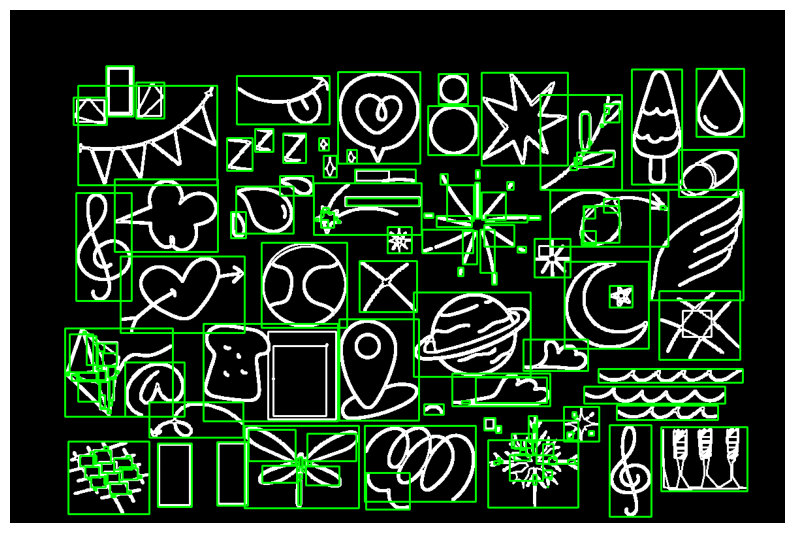

Detected shapes and their counts:
circle(16)
ellipse(137)
rectangle(17)
regularPolygon(0)
roundedRectangle(0)
star(3)
straightLine(0)
unknown(25)


In [ ]:
shape_counts = detect_shapes('output_regularised4.png')

ML Based Shape Detection

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [10]:
data_dir = '/content/dataset'

Epoch 1/10: 100%|██████████| 329/329 [00:21<00:00, 15.18it/s]


New best model saved with accuracy: 0.7651
Epoch 1, Train Loss: 0.7060, Val Loss: 0.4775, Val Accuracy: 0.7651


Epoch 2/10: 100%|██████████| 329/329 [00:19<00:00, 17.15it/s]


New best model saved with accuracy: 0.8223
Epoch 2, Train Loss: 0.3491, Val Loss: 0.3336, Val Accuracy: 0.8223


Epoch 3/10: 100%|██████████| 329/329 [00:18<00:00, 17.54it/s]


New best model saved with accuracy: 0.8689
Epoch 3, Train Loss: 0.2867, Val Loss: 0.2783, Val Accuracy: 0.8689


Epoch 4/10: 100%|██████████| 329/329 [00:18<00:00, 17.56it/s]


New best model saved with accuracy: 0.9034
Epoch 4, Train Loss: 0.2337, Val Loss: 0.2243, Val Accuracy: 0.9034


Epoch 5/10: 100%|██████████| 329/329 [00:18<00:00, 17.57it/s]


New best model saved with accuracy: 0.9434
Epoch 5, Train Loss: 0.1431, Val Loss: 0.1655, Val Accuracy: 0.9434


Epoch 6/10: 100%|██████████| 329/329 [00:18<00:00, 17.81it/s]


New best model saved with accuracy: 0.9526
Epoch 6, Train Loss: 0.0875, Val Loss: 0.1225, Val Accuracy: 0.9526


Epoch 7/10: 100%|██████████| 329/329 [00:18<00:00, 17.40it/s]


New best model saved with accuracy: 0.9589
Epoch 7, Train Loss: 0.0738, Val Loss: 0.1201, Val Accuracy: 0.9589


Epoch 8/10: 100%|██████████| 329/329 [00:18<00:00, 18.01it/s]


New best model saved with accuracy: 0.9629
Epoch 8, Train Loss: 0.0558, Val Loss: 0.1069, Val Accuracy: 0.9629


Epoch 9/10: 100%|██████████| 329/329 [00:18<00:00, 18.21it/s]


Epoch 9, Train Loss: 0.0474, Val Loss: 0.1226, Val Accuracy: 0.9543


Epoch 10/10: 100%|██████████| 329/329 [00:18<00:00, 17.91it/s]


Epoch 10, Train Loss: 0.0485, Val Loss: 0.1094, Val Accuracy: 0.9614
Training complete. Best validation accuracy: 0.9629


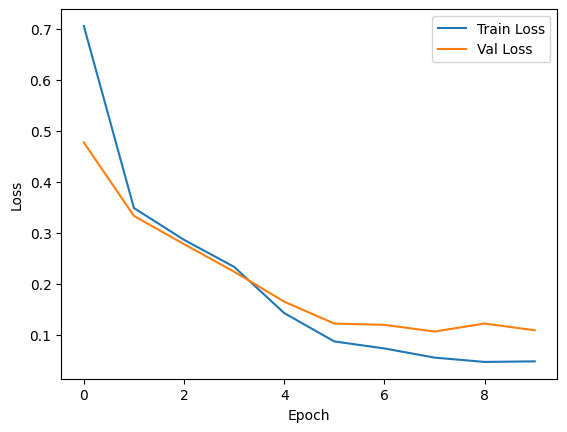

In [8]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=7)

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_accuracy = 0.0
    best_model_path = 'best_model.pth'

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_predictions += (preds == labels).sum().item()
                total_predictions += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_predictions / total_predictions
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with accuracy: {best_val_accuracy:.4f}")

        model.train()

        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    print(f"Training complete. Best validation accuracy: {best_val_accuracy:.4f}")
    return train_losses, val_losses, val_accuracies

train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

import numpy as np

full_dataset = datasets.ImageFolder(data_dir, transform=transform)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)

def find_shapes_in_image(image_path, model, class_names):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    with open(image_path, 'rb') as f:
        pil_image = Image.open(f)
        pil_image = pil_image.convert('RGB')

    image = np.array(pil_image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edged = cv2.Canny(gray, 30, 150)

    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected_shapes = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        roi = image[y:y+h, x:x+w]
        pil_image_roi = Image.fromarray(roi)
        input_tensor = transform(pil_image_roi).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            _, preds = torch.max(outputs, 1)
            detected_shapes.append(class_names[preds.item()])

        plt.imshow(pil_image_roi)
        plt.title(f"Predicted: {class_names[preds.item()]}")
        plt.axis('off')
        plt.show()

    return detected_shapes

class_names = ['circle', 'ellipse', 'rectangle', 'regularPolygon', 'roundedRectangle', 'star', 'straightLine']

In [14]:
from PIL import Image
import cv2

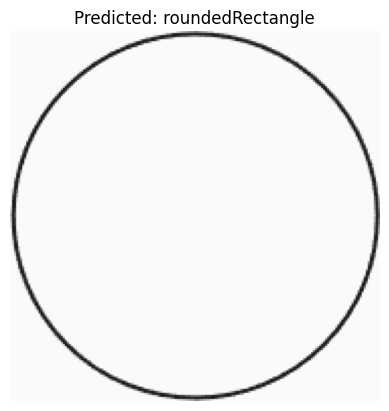

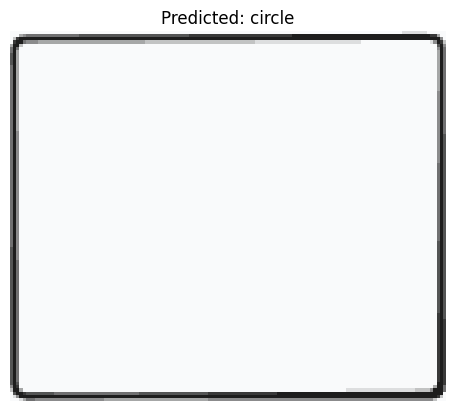

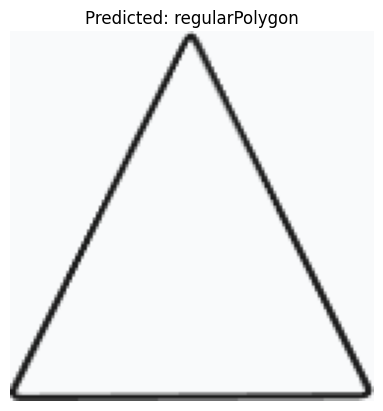

Detected shapes: ['roundedRectangle', 'circle', 'regularPolygon']


In [15]:
image_path = '/content/shape.png'
detected_shapes = find_shapes_in_image(image_path, model, class_names)
print(f'Detected shapes: {detected_shapes}')

Genetic Detector

Creating population...
Initiating GA heuristic approach...
error: 0.3248524647979265
error: 0.3242483263292859
error: 0.3259028743206007
error: 0.3162408753149384
error: 0.31838580348034307
error: 0.32219638741807866
error: 0.3204304514846914
error: 0.31933574488880145
error: 0.31556738085195357
error: 0.31553216489480906


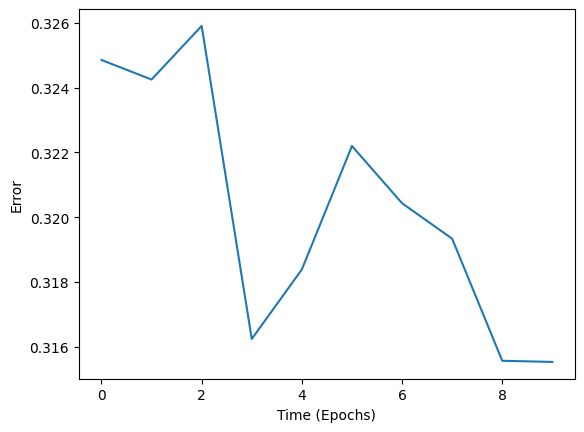

--------------------------------------------------------------

Initiating Gradient Descent optimization...
Epoch: 0 error: 0.324436345432189 accuracy: 0.52 train_accuracy: 0.3404255319148936
Epoch: 1 error: 0.32265995020258353 accuracy: 0.5 train_accuracy: 0.4521276595744681
Epoch: 2 error: 0.3213457298325653 accuracy: 0.5 train_accuracy: 0.4627659574468085
Epoch: 3 error: 0.3203089061850072 accuracy: 0.52 train_accuracy: 0.4308510638297872
Epoch: 4 error: 0.31944191717212406 accuracy: 0.6 train_accuracy: 0.4308510638297872


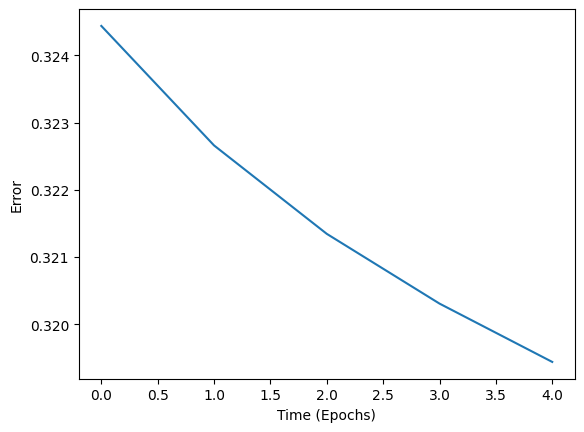

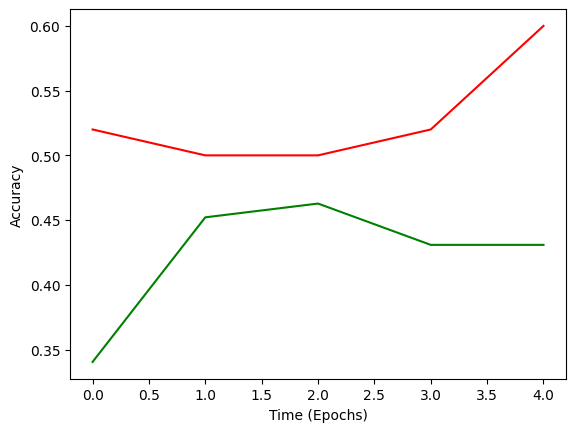

Done!
Accuracy: 0.6


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import PIL
import random
import pickle
import imageio.v2 as imageio

# define acctivation function params
tansig = lambda n: 2 / (1 + np.exp(-2 * n)) - 1
sigmoid = lambda n: 1 / (1 + np.exp(-n))
hardlim = lambda n: np.where(n >= 0, 1, 0)
purelin = lambda n: n
relu = lambda n: np.maximum(0, n)
square_error = lambda x, y: np.sum(0.5 * (x - y)**2)
sig_prime = lambda z: sigmoid(z) * (1 - sigmoid(z))
relu_prime = lambda z: np.where(z > 0, 1, 0)
softmax = lambda n: np.exp(n - np.max(n, axis=0, keepdims=True)) / np.sum(np.exp(n - np.max(n, axis=0, keepdims=True)), axis=0)
softmax_prime = lambda n: softmax(n) * (1 - softmax(n))
cross_entropy = lambda x, y: -np.sum(x * np.log(y + 1e-8))

from random import randint
import copy

class GAKill(Exception):
    def __init__(self, message):
        self.message = message

class Gene:
    fitness = 0
    score = 0
    genotype = []
    cursor = 0

    def __init__(self):
        pass

    def encode(self):
        pass

    def decode(self):
        pass

    def evaluate(self, data, targets):
        pass

    def mutate(self, rate):
        gen_len = len(self.genotype)

        idx = np.random.randint(0, gen_len, size=int(round(rate * gen_len)))
        self.genotype[idx] += 0.1 * (2 * np.random.random_sample(len(idx)) - 1)

    def read_genotype(self, delta):
        chunk = self.genotype[self.cursor:self.cursor + delta]
        self.cursor += delta
        return chunk

class GeneticAlgorithm:
    popsize = 0
    error = 1
    epoch = 0
    armageddon = 0

    def __init__(self, epochs, mutation_rate, data, targets, obj, args):
        self.obj = obj
        self.args = args
        self.mutation_rate = mutation_rate
        self.training_data = data
        self.targets = targets
        self.armageddon = epochs

    def populate(self, size):
        self.population = [self.obj(self.args) for _ in range(size)]
        self.popsize = size

    def singleton(self):
        return self.obj(self.args, build=False)

    def evaluate(self):
        for gene in self.population:
            gene.evaluate(self.training_data, self.targets)

        self.population = sorted(self.population, key=lambda gene: gene.fitness)
        self.error = 1 - self.fittest().fitness

    def crossover(self):
        population = [self.breed(self.roulette(2)) for _ in range(self.popsize)]
        self.population = population

    def breed(self, parents):
        offspring = self.singleton()
        length = parents[0].genotype.size - 1
        cuts = [randint(0, length // 2), randint(length // 2, length)]

        offspring.genotype = np.concatenate((parents[0].genotype[:cuts[0]],
                                              parents[1].genotype[cuts[0]:cuts[1]],
                                              parents[0].genotype[cuts[1]:]))

        offspring.mutate(self.mutation_rate)
        offspring.decode()

        return offspring

    def roulette(self, n):
        choice = self.population[-self.popsize // 2:]
        fitnesses = np.array([x.fitness for x in choice])
        fitnesses /= np.sum(fitnesses)

        return np.random.choice(choice, n, p=fitnesses)

    def fittest(self):
        return copy.deepcopy(self.population[-1])

    def evolve(self):
        return self.epoch < self.armageddon

class NeuralNet(Gene):
    errors = []
    test_accuracies = []
    train_accuracies = []
    alpha_max = 0.8
    alpha_min = 0.1
    decay_speed = 100

    def __init__(self, args, build=True):
        self.biases = []
        self.weights = []
        self.skeleton = args
        if build:
            self.build(self.skeleton)
            self.encode()

    def build(self, skeleton):
        for i, width in enumerate(skeleton[1:], start=1):
            weights = (2 * np.random.random((width, skeleton[i-1])) - 1)
            biases = (2 * np.random.random(width) - 1)
            self.weights.append(weights)
            self.biases.append(biases)

        self.n = len(self.weights) + 1

    def feed_forward(self, activation):
        zs = []
        activations = [activation]
        z = activation

        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        z = np.dot(self.weights[-1], activation) + self.biases[-1]
        zs.append(z)
        activations.append(softmax(z))
        return activations, zs

    def backpropagate(self, activation, target):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activations, zs = self.feed_forward(activation)
        self.errors[-1] += square_error(target, activations[-1])
        if np.argmax(target) == np.argmax(activations[-1]):
            self.train_accuracies[-1] += 1

        delta = softmax_prime(zs[-1]) * (activations[-1] - target)

        nabla_w[-1] = np.outer(delta, activations[-2])
        nabla_b[-1] = delta

        for i in range(2, self.n):
            delta = np.dot(self.weights[-i+1].T, delta) * sig_prime(zs[-i])

            nabla_w[-i] = np.outer(delta, activations[-i-1])
            nabla_b[-i] = delta

        return nabla_w, nabla_b

    def gradient_descent(self, training_data, targets, epochs, test_data=None, vis=False):
        m = len(training_data)

        for i in range(epochs):
            nabla_b = [np.zeros(b.shape) for b in self.biases]
            nabla_w = [np.zeros(w.shape) for w in self.weights]
            self.errors.append(0)
            self.train_accuracies.append(0)

            for tag, img in training_data:
                target = np.array([int(x in tag) for x in targets])
                delta_nabla_w, delta_nabla_b = self.backpropagate(img, target)

                for j in range(self.n - 1):
                    nabla_w[j] += delta_nabla_w[j]
                    nabla_b[j] += delta_nabla_b[j]

            self.weights = [w - (self.learning_rate(i) / m) * nw for w, nw in zip(self.weights, nabla_w)]
            self.biases = [b - (self.learning_rate(i) / m) * nb for b, nb in zip(self.biases, nabla_b)]

            if test_data:
                self.test_accuracies.append(self.validate(targets, test_data))

            self.errors[-1] /= m
            self.train_accuracies[-1] /= float(m)
            print(f"Epoch: {i} error: {self.errors[-1]} accuracy: {self.test_accuracies[-1]} train_accuracy: {self.train_accuracies[-1]}")

        if vis:
            plt.figure(1)
            plt.plot(range(epochs), self.errors)
            plt.xlabel('Time (Epochs)')
            plt.ylabel('Error')

            plt.figure(2)
            plt.plot(range(epochs), self.train_accuracies, 'g')
            plt.plot(range(epochs), self.test_accuracies, 'r')
            plt.xlabel('Time (Epochs)')
            plt.ylabel('Accuracy')

            plt.show()

    def validate(self, targets, test_data):
        accuracy = 0.0
        for tag, img in test_data:
            target = np.array([int(x in tag) for x in targets])
            activations, zs = self.feed_forward(img)

            if np.argmax(target) == np.argmax(activations[-1]):
                accuracy += 1

        return accuracy / len(test_data)

    def learning_rate(self, i):
        return self.alpha_min + (self.alpha_max - self.alpha_min) * np.exp(-i / self.decay_speed)

    def load(self, filename):
        with open(filename, "rb") as f:
            self.weights, self.biases = pickle.load(f)

    def save(self, filename):
        with open(filename, "wb") as f:
            pickle.dump((self.weights, self.biases), f)

    def encode(self):
        genotype = np.array([])
        for w, b in zip(self.weights, self.biases):
            genotype = np.concatenate((genotype, w.flatten(), b))

        self.genotype = genotype

    def decode(self):
        self.weights = []
        self.biases = []
        for i, width in enumerate(self.skeleton[1:], start=1):
            d = self.skeleton[i-1] * width
            weights = self.read_genotype(d).reshape(width, self.skeleton[i-1])
            biases = self.read_genotype(width)
            self.weights.append(weights)
            self.biases.append(biases)

        self.cursor = 0
        self.n = len(self.weights) + 1

    def evaluate(self, training_data, targets):
        error = 0

        for tag, img in training_data:
            target = np.array([int(x in tag) for x in targets])
            activations, zs = self.feed_forward(img)
            error += square_error(activations[-1], target)

        self.fitness = 1 - error / len(training_data)

def read_data(path):
    data = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for f in filenames:
            try:
                img_path = os.path.join(dirpath, f)
                img = imageio.imread(img_path, mode='L')
                img = np.ravel(img) / 255.0
                label = os.path.basename(dirpath)
                data.append((label, img))
            except Exception as e:
                print(f"Error reading file {img_path}: {e}")
    if not data:
        print("Warning: No data found in the specified directory.")
    return data

def train_ga(num_ga_epochs, num_sgd_epochs, vis_flag):
    training_data = read_data('/content/dataset/train/')
    test_data = read_data('/content/dataset/test/')
    random.shuffle(training_data)
    img_len = len(training_data[0][1])
    ga = GeneticAlgorithm(epochs=int(num_ga_epochs),
                          mutation_rate=0.01,
                          data=training_data,
                          targets=targets,
                          obj=NeuralNet,
                          args=[img_len, 10, 4, 3])

    print("Creating population...")
    ga.populate(200)
    print("Initiating GA heuristic approach...")
    errors = []
    while ga.evolve():
        try:
            ga.evaluate()
            ga.crossover()
            ga.epoch += 1

            errors.append(ga.error)
            print("error: " + str(ga.error))
        except GAKill as e:
            print(e.message)
            break

    vis = bool(int(vis_flag))
    if vis:
        fig = plt.figure()
        plt.plot(range(ga.epoch), errors)
        plt.xlabel('Time (Epochs)')
        plt.ylabel('Error')
        plt.show()

    print("--------------------------------------------------------------\n")

    nn = ga.fittest()
    if num_sgd_epochs:
        print("Initiating Gradient Descent optimization...")
        try:
            nn.gradient_descent(training_data, targets, int(num_sgd_epochs), test_data=test_data, vis=vis)
        except GAKill as e:
            print(e.message)

    nn.save("neuralnet.pkt")
    print("Done!")

def validate():
    test_data = read_data('/content/dataset/test/')
    nn = NeuralNet([], build=False)
    nn.load("neuralnet.pkt")
    accuracy = nn.validate(targets, test_data)
    print("Accuracy: " + str(accuracy))

def predict(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((100, 100))
    img = np.array(img).flatten()
    img = img / 255.0

    nn = NeuralNet([], build=False)
    nn.load("neuralnet.pkt")

    activations, zs = nn.feed_forward(img)
    print(targets[np.argmax(activations[-1])])


targets = np.array(['circle', 'ellipse', 'rectangle', 'regularPolygon', 'roundedRectangle', 'star', 'straightLine'])
train_ga(num_ga_epochs=10, num_sgd_epochs=5, vis_flag=1)
validate()


T

This image `a5.png` had a hand drawn 'circle', a 'rectange' and a 'star'.
The image is avaiable in the github repository under Datasets/Test_Self.


In [ ]:
predict('a5.png')

rectangle


### Triangulation

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    return val

def convexHull(points):
    n = len(points)
    if n < 3:
        return []

    l = 0
    for i in range(1, len(points)):
        if points[i][0] < points[l][0]:
            l = i
        elif points[i][0] == points[l][0]:
            if points[i][1] > points[l][1]:
                l = i

    hull = []
    p = l
    while True:
        hull.append(points[p])
        q = (p + 1) % n
        for i in range(n):
            if orientation(points[p], points[i], points[q]) < 0:
                q = i
        p = q
        if p == l:
            break

    return hull

def dist(p1, p2):
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def cost(p1, p2, p3):
    return dist(p1, p2) + dist(p2, p3) + dist(p3, p1)

def triangulation(points):
    n = len(points)
    if n < 3:
        return []

    table = [[(float('inf'), -1)] * n for _ in range(n)]
    for gap in range(n):
        for j in range(gap, n):
            i = j - gap
            if j < i + 2:
                table[i][j] = (0.0, -1)
            else:
                for k in range(i + 1, j):
                    val = table[i][k][0] + table[k][j][0] + cost(points[i], points[j], points[k])
                    if table[i][j][0] > val:
                        table[i][j] = (val, k)

    queue = [[0, n - 1]]
    triangles = []
    while queue:
        x = queue.pop(0)
        k = table[x[0]][x[1]][1]
        if k - x[0] > 2:
            queue.append([x[0], k])
        if x[1] - k > 2:
            queue.append([k, x[1]])
        triangles.append([points[x[0]], points[k], points[x[1]]])

    return triangles

def detect_shapes(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for cnt in contours:
        epsilon = 0.02 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        if len(approx) >= 3:
            if len(approx) == 3:
                shape = 'Triangle'
            elif len(approx) == 4:
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = float(w) / h
                shape = 'Rectangle' if 0.9 <= aspect_ratio <= 1.1 else 'Quadrilateral'
            else:
                area = cv2.contourArea(approx)
                hull = cv2.convexHull(approx, returnPoints=True)
                hull_area = cv2.contourArea(hull)
                shape = 'Circle' if abs(1 - (area / hull_area)) <= 0.2 else 'Polygon'
            shapes.append((shape, approx))

    return shapes

def plot_shapes_and_triangles(image_path):
    shapes = detect_shapes(image_path)

    image = plt.imread(image_path)
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(image.shape[0], 0)

    for shape, contour in shapes:
        polygon = [(point[0][0], point[0][1]) for point in contour]
        convex_polygon = convexHull(polygon)
        polygon_patch = patches.Polygon(convex_polygon, closed=True, edgecolor='white', facecolor='none', linewidth=2)
        ax.add_patch(polygon_patch)

        color = {'Triangle': 'blue', 'Rectangle': 'green', 'Circle': 'orange', 'Polygon': 'purple'}
        ax.text(np.mean([p[0] for p in polygon]), np.mean([p[1] for p in polygon]),
                shape, color=color.get(shape, 'black'), fontsize=12, weight='bold')

        triangles = triangulation(convex_polygon)
        for triangle in triangles:
            triangle_patch = patches.Polygon(triangle, closed=True, edgecolor='red', facecolor='none', linestyle='--')
            ax.add_patch(triangle_patch)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

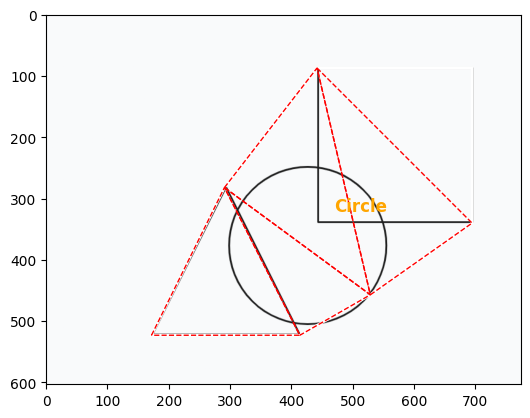

In [ ]:
image_path = 'a6.png'
plot_shapes_and_triangles(image_path)

Shape Completion

In [1]:
import gdown
!gdown 1TUVYrFghJfXaLElIZLKLYO3FSpPStDPM

Downloading...
From (original): https://drive.google.com/uc?id=1TUVYrFghJfXaLElIZLKLYO3FSpPStDPM
From (redirected): https://drive.google.com/uc?id=1TUVYrFghJfXaLElIZLKLYO3FSpPStDPM&confirm=t&uuid=1b99f95c-992a-458d-9883-ac5718ed4616
To: /content/shape_completion.zip
100% 10.3M/10.3M [00:00<00:00, 132MB/s]


In [29]:
!pip install --upgrade scipy==1.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.0
    Uninstalling scipy-1.14.0:
      Successfully uninstalled scipy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from scipy.spatial import ConvexHull, Delaunay
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def bezier_curve(points, n=3, num_points=1000):
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))
    for i in range(n + 1):
        bernstein = comb(n, i) * (t ** i) * ((1 - t) ** (n - i))
        curve += np.outer(bernstein, points[i])
    return curve

def fit_bezier(XYs, n=3):
    bezier_curves = []
    for XY in XYs:
        if len(XY) > n:
            X = np.linspace(0, 1, len(XY)).reshape(-1, 1)
            poly = PolynomialFeatures(degree=n).fit_transform(X)
            model = LinearRegression().fit(poly, XY)
            t = np.linspace(0, 1, 100).reshape(-1, 1)
            poly_t = PolynomialFeatures(degree=n).fit_transform(t)
            bezier_points = model.predict(poly_t)
            bezier_curves.append(bezier_points)
    return bezier_curves

def complete_shapes(XYs):
    completed_shapes = []
    for XY in XYs:
        if len(XY) > 5:
            try:
                hull = ConvexHull(XY)
                completed_shapes.append(XY[hull.vertices])
            except:
                if len(XY) > 3:
                    delaunay = Delaunay(XY)
                    for simplex in delaunay.simplices:
                        completed_shapes.append(XY[simplex])
    return completed_shapes

def plot(path_XYs, bezier_curves, completed_shapes, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(12, 8))

    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, markersize=5)

    for i, bezier in enumerate(bezier_curves):
        c = colours[i % len(colours)]
        if bezier.size > 0:
            ax.plot(bezier[:, 0], bezier[:, 1], c=c, linewidth=2)

    for i, shape in enumerate(completed_shapes):
        c = colours[i % len(colours)]
        ax.plot(shape[:, 0], shape[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    ax.set_title('Bézier Curves and Completed Shapes')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.grid(True)
    plt.show()

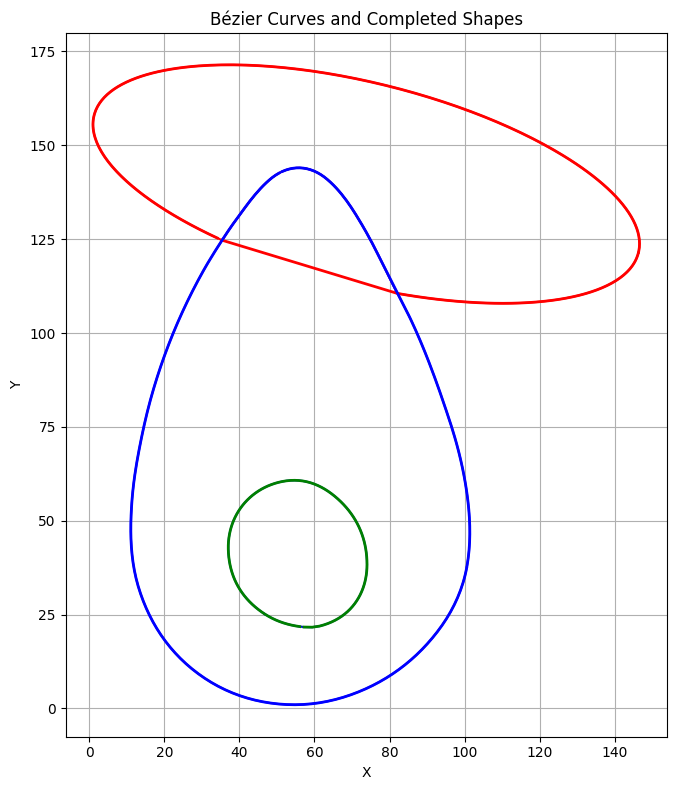

In [39]:
csv_path = '/content/problems/problems/occlusion1.csv'

path_XYs = read_csv(csv_path)
bezier_curves = fit_bezier(path_XYs, n=3)
completed_shapes = complete_shapes([XY for XYs in path_XYs for XY in XYs])
plot(path_XYs, bezier_curves, completed_shapes, colours=['r', 'b', 'g', 'y'])

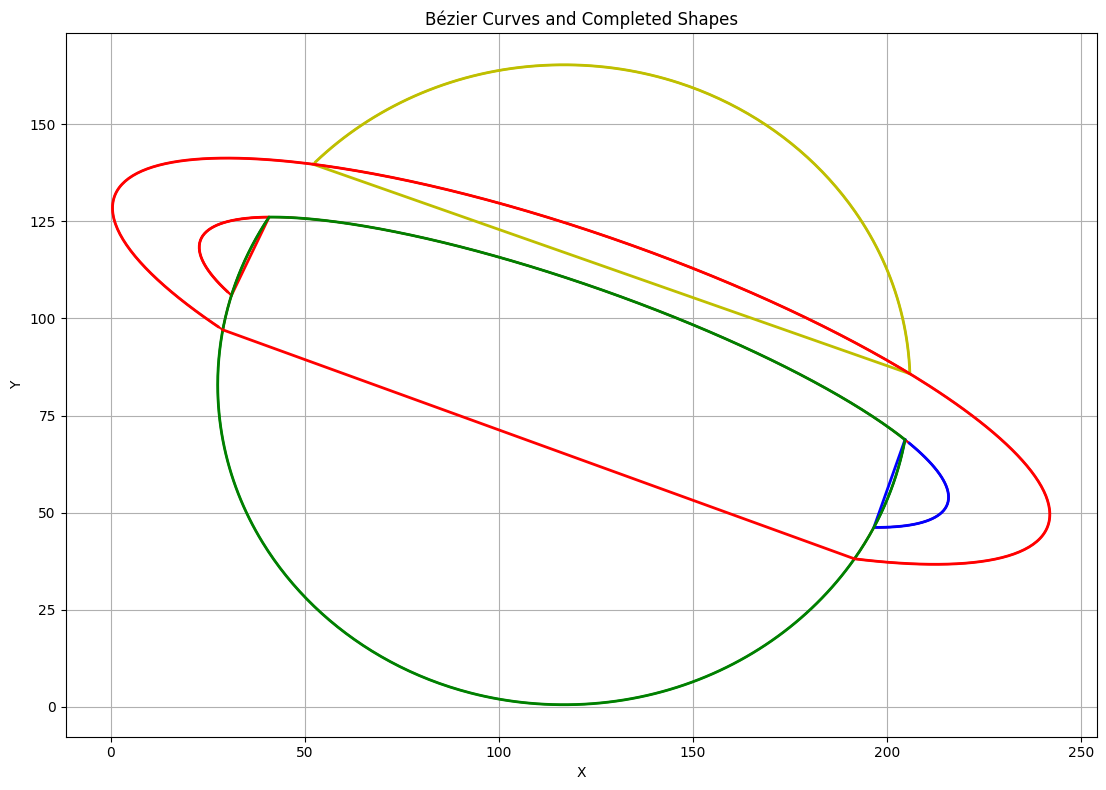

In [40]:
csv_path = '/content/problems/problems/occlusion2.csv'
path_XYs = read_csv(csv_path)
bezier_curves = fit_bezier(path_XYs, n=3)
completed_shapes = complete_shapes([XY for XYs in path_XYs for XY in XYs])
plot(path_XYs, bezier_curves, completed_shapes, colours=['r', 'b', 'g', 'y'])